In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_coherence import coherence_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline
import mne
import os
from configuration import base_folder

In [2]:
concat = []
for run_key in run_keys:
    concat.append(coherence_at_resp_job.get(run_key).to_dataframe())
coherence = pd.concat(concat)

In [3]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [4]:
coherence = coherence.set_index(indexes).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])

In [5]:
coherence

participant   session chan  fmax_resp     max_resp  max_coherence   
0            P01  baseline  Fp1   0.356259   882.435901       0.027298  \
1            P01  baseline   Fz   0.356259   882.435901       0.093940   
2            P01  baseline   F3   0.356259   882.435901       0.080578   
3            P01  baseline   F7   0.356259   882.435901       0.026322   
4            P01  baseline  FT9   0.356259   882.435901       0.027211   
...          ...       ...  ...        ...          ...            ...   
2785         P31      odor  FC6   0.187505  3123.367996       0.213817   
2786         P31      odor  FC2   0.187505  3123.367996       0.148870   
2787         P31      odor   F4   0.187505  3123.367996       0.494977   
2788         P31      odor   F8   0.187505  3123.367996       0.171321   
2789         P31      odor  Fp2   0.187505  3123.367996       0.059148   

      log_max_coherence  
0             -3.600945  
1             -2.365099  
2             -2.518531  
3             -3.637365  
4             -3.604137  
...                 ...  
2785          -1.542636  
2786          -1.904684  
2787          -0.703244  
2788          -1.764215  
2789          -2.827718  

[2790 rows x 7 columns]

In [6]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [7]:
coherence_baselined

participant session chan  fmax_resp     max_resp  max_coherence   
0            P01    odor  Fp1   0.000000  -457.441046      -0.019530  \
1            P01    odor   Fz   0.000000  -457.441046      -0.025588   
2            P01    odor   F3   0.000000  -457.441046       0.007871   
3            P01    odor   F7   0.000000  -457.441046      -0.023718   
4            P01    odor  FT9   0.000000  -457.441046      -0.017519   
...          ...     ...  ...        ...          ...            ...   
1855         P31   music  FC6  -0.075002  3309.960658       0.244107   
1856         P31   music  FC2  -0.075002  3309.960658       0.172465   
1857         P31   music   F4  -0.075002  3309.960658       0.357088   
1858         P31   music   F8  -0.075002  3309.960658       0.306448   
1859         P31   music  Fp2  -0.075002  3309.960658       0.167314   

      log_max_coherence  
0             -1.256856  
1             -0.317985  
2              0.093200  
3             -2.313502  
4             -1.032374  
...                 ...  
1855           3.749201  
1856           1.905568  
1857           1.838866  
1858           3.204819  
1859           1.633281  

[1860 rows x 7 columns]

<AxesSubplot: >

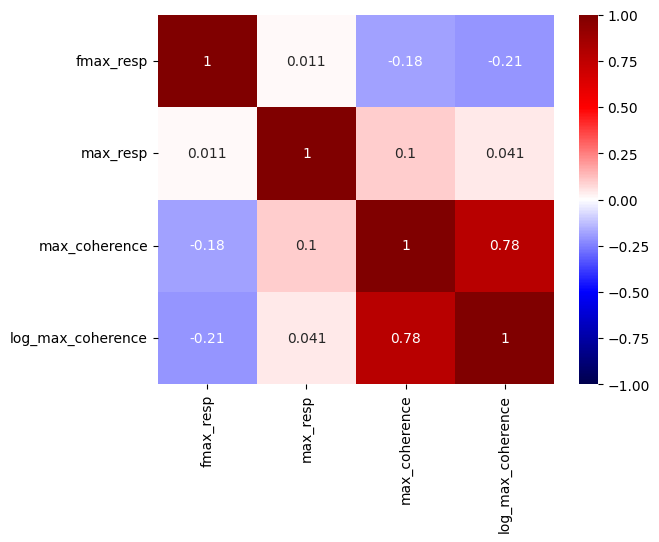

In [9]:
sns.heatmap(coherence.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

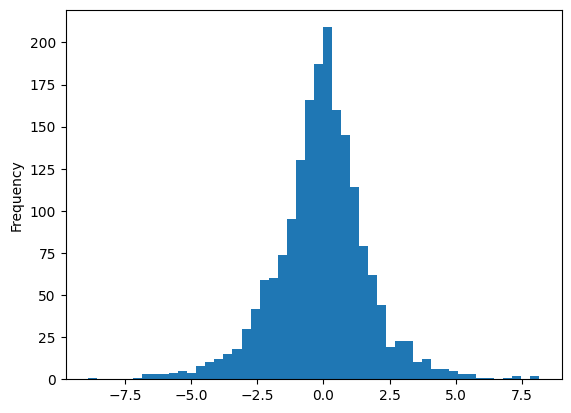

In [10]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

In [11]:
pos = get_pos()

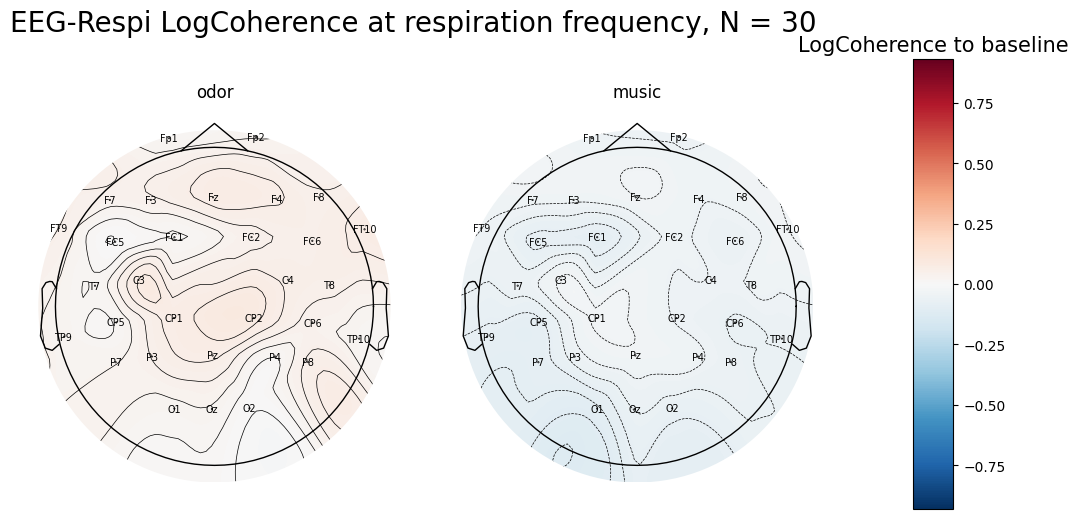

In [12]:
q_diff = 0.

df = coherence_baselined

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogCoherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'log_coherence_substract_baseline.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

/tmp/ipykernel_2038926/1421536056.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))


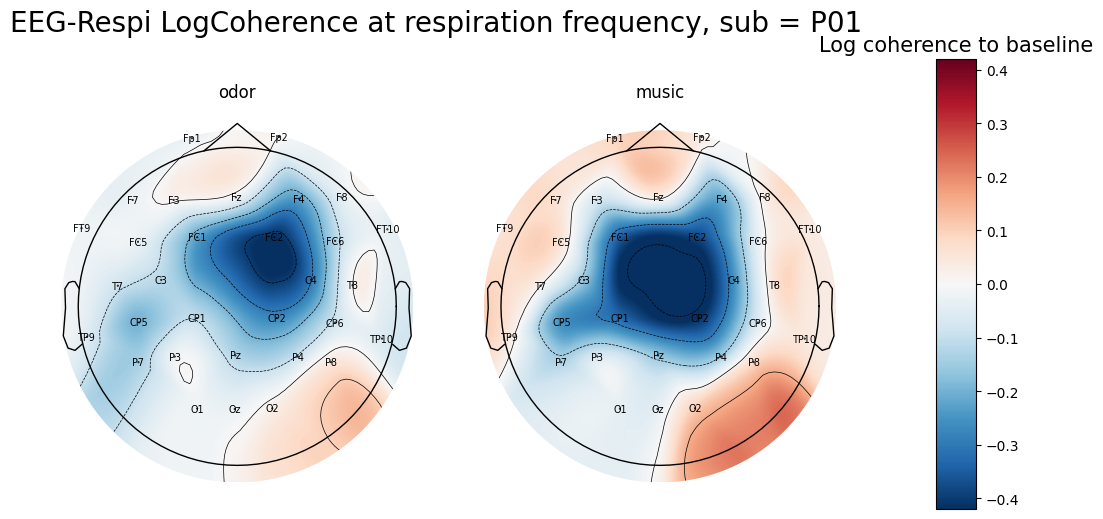

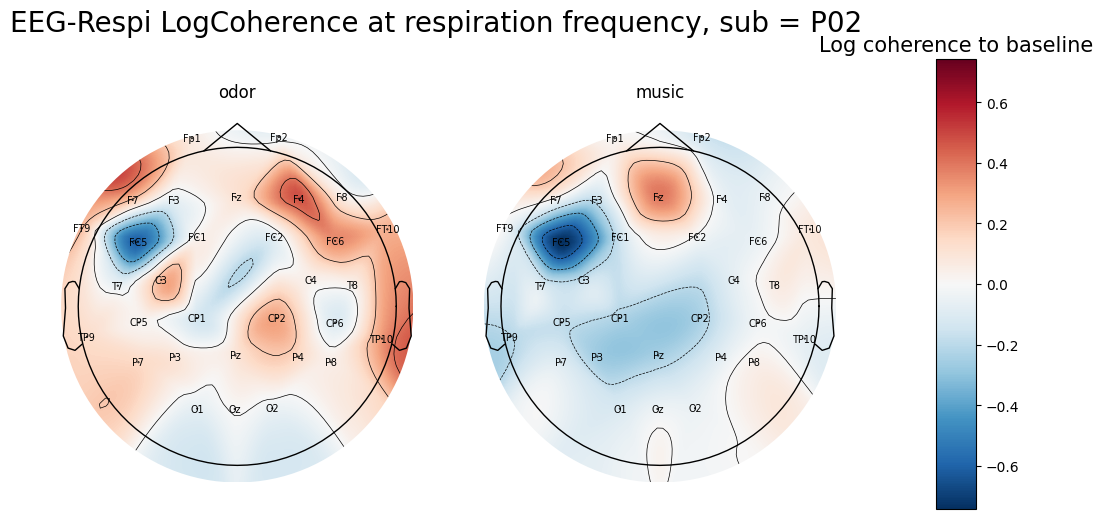

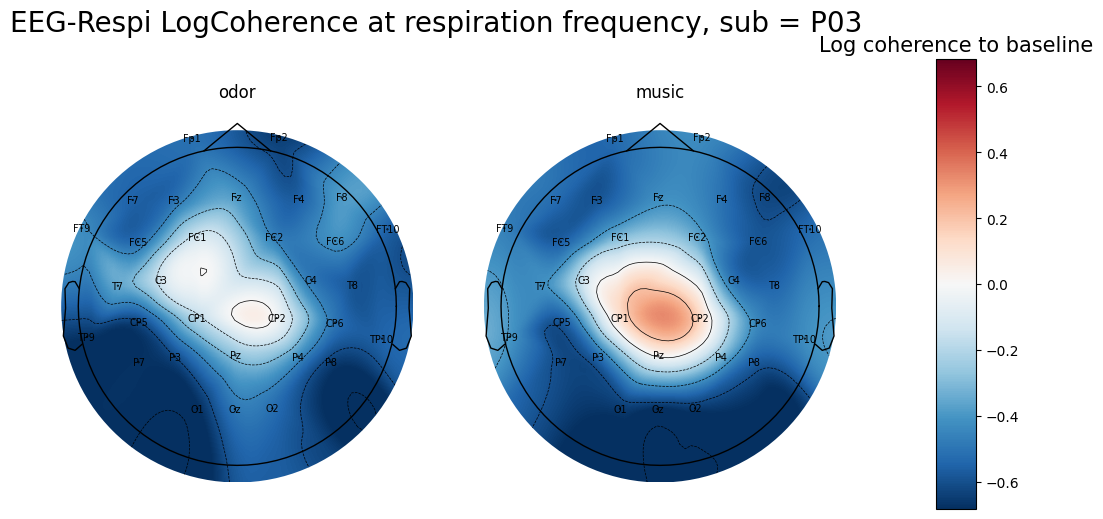

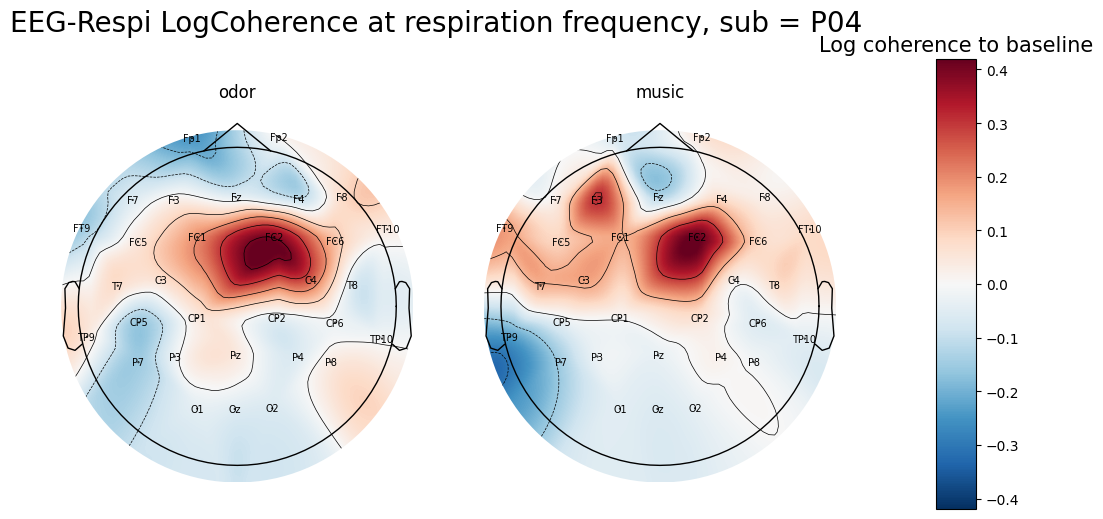

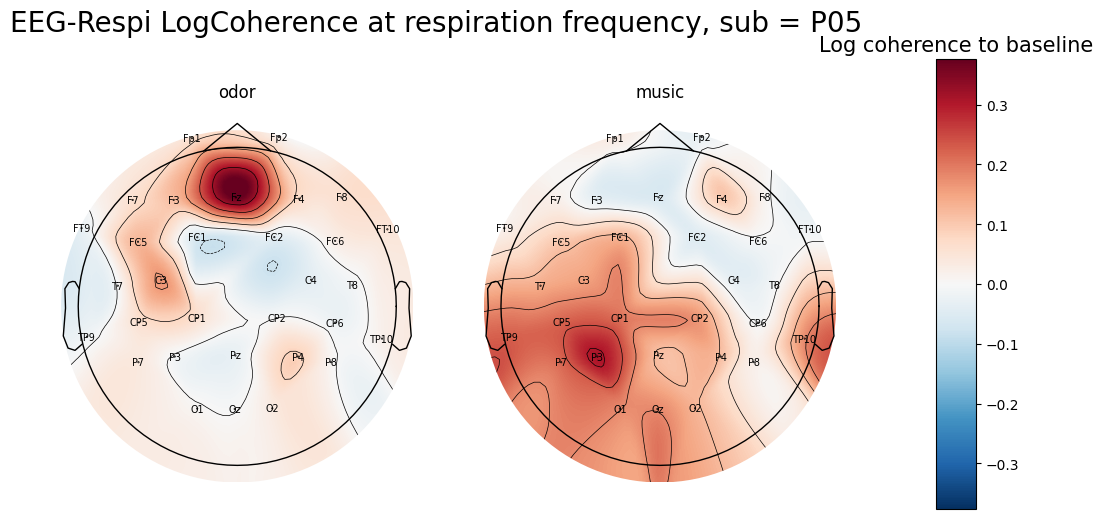

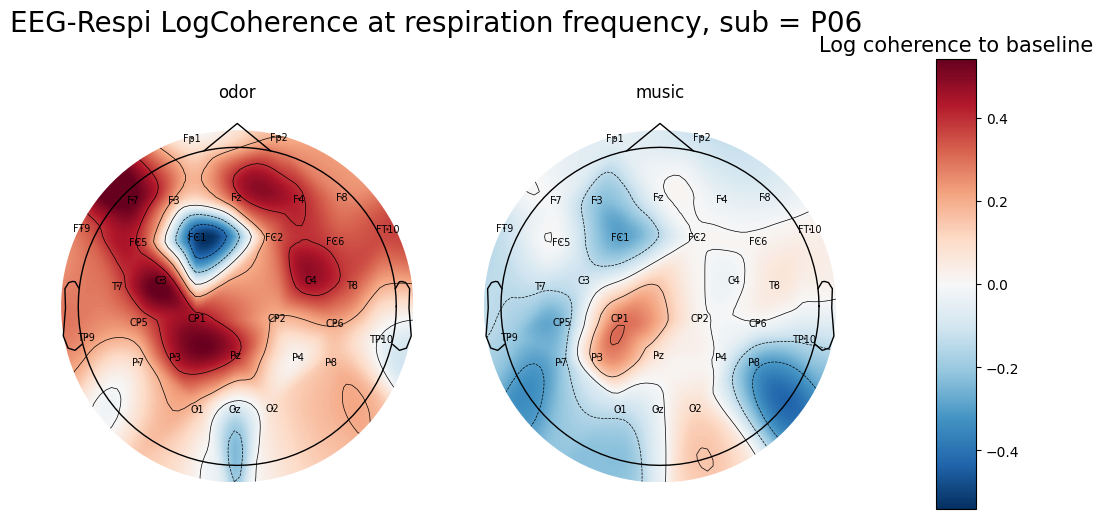

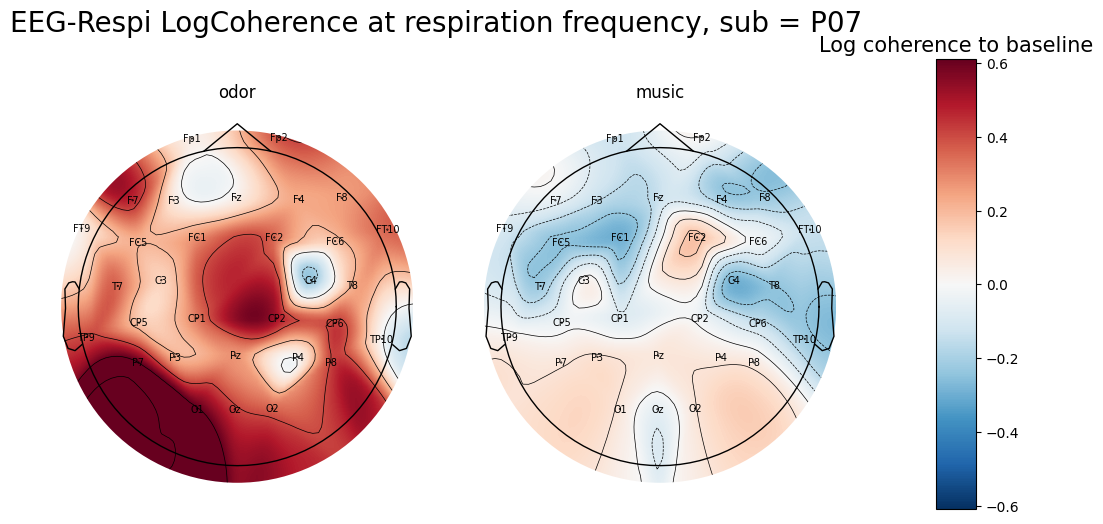

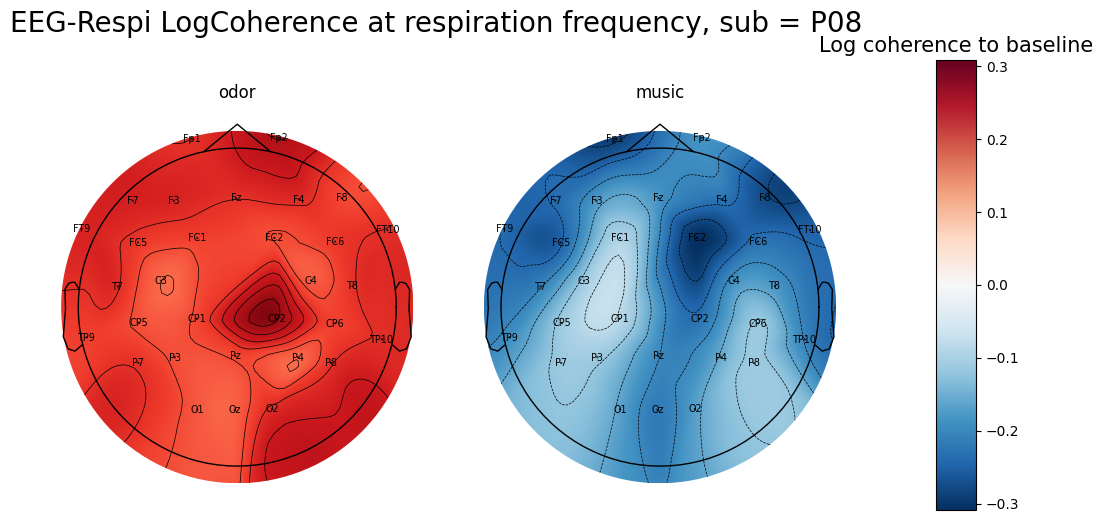

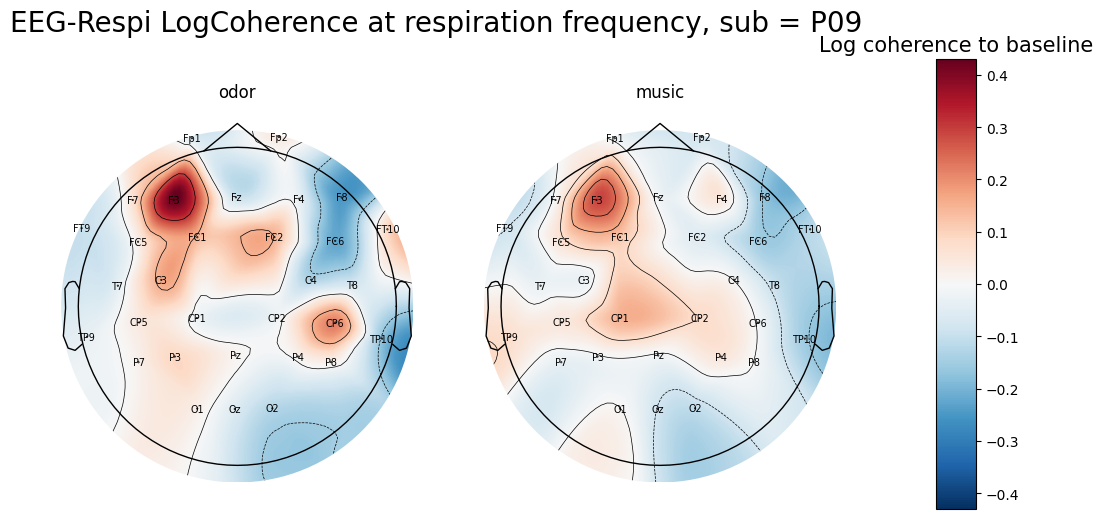

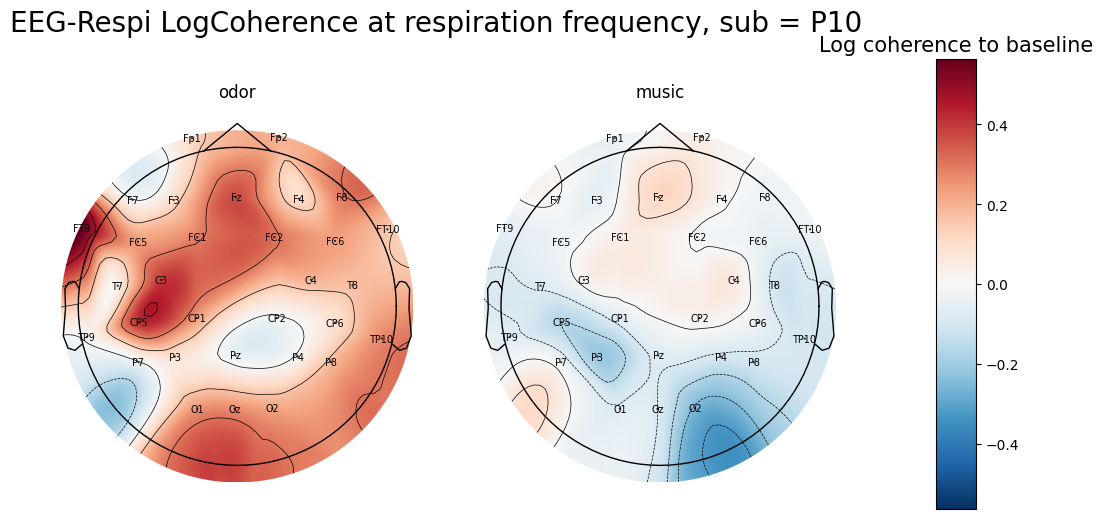

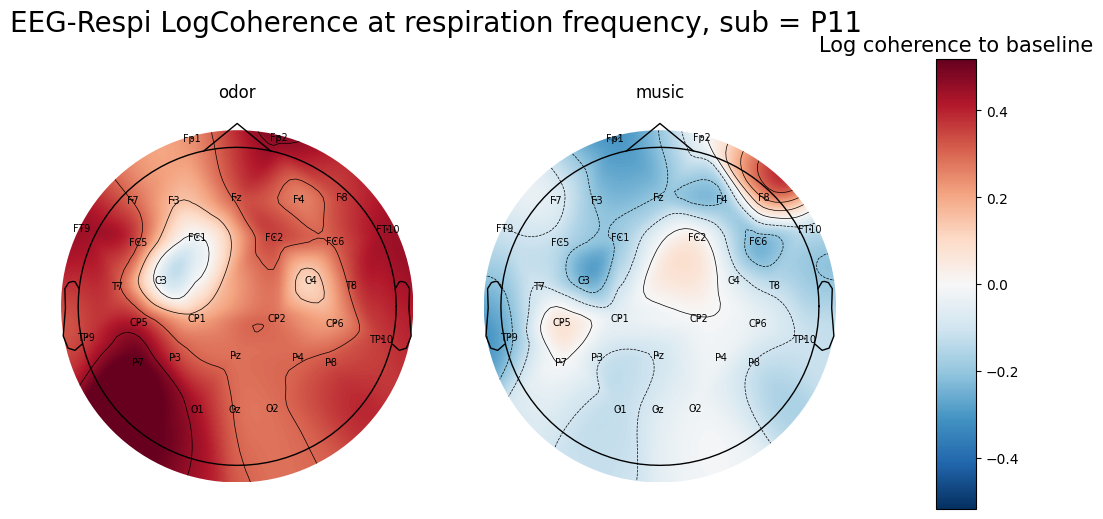

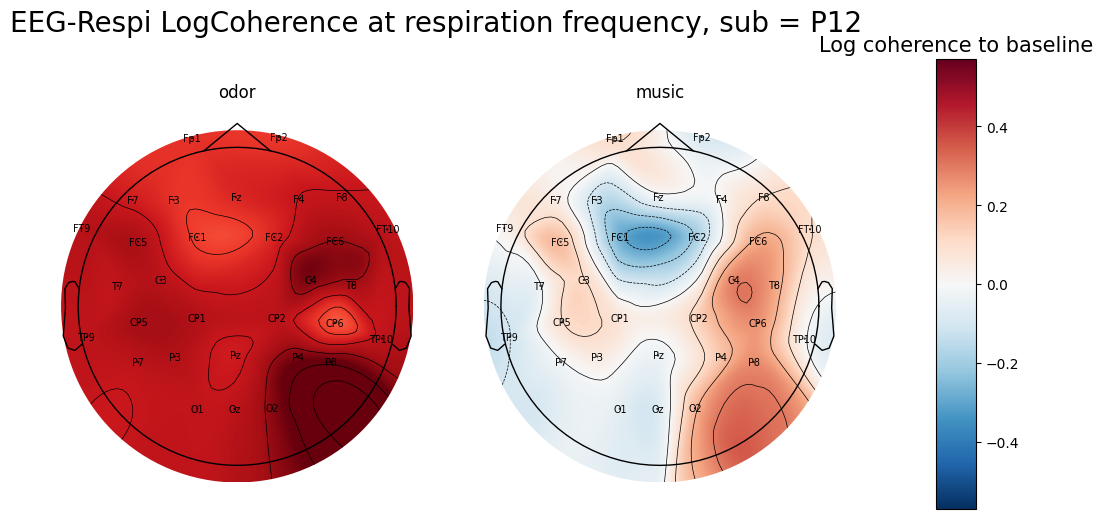

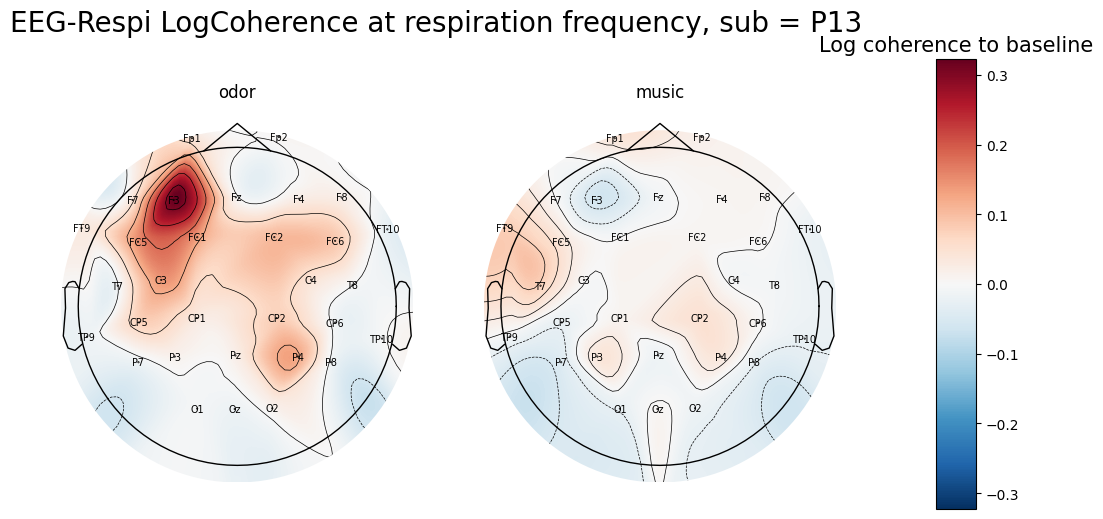

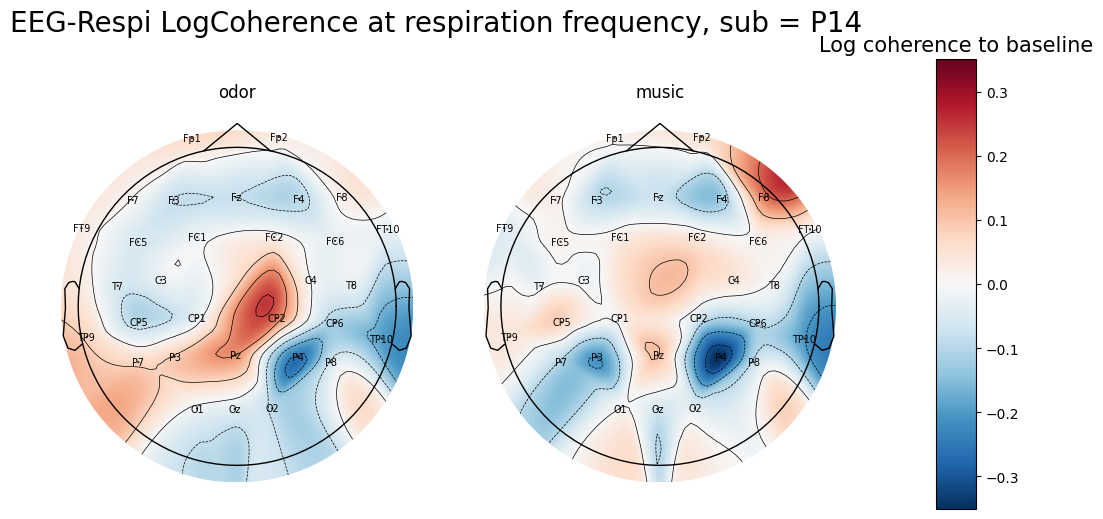

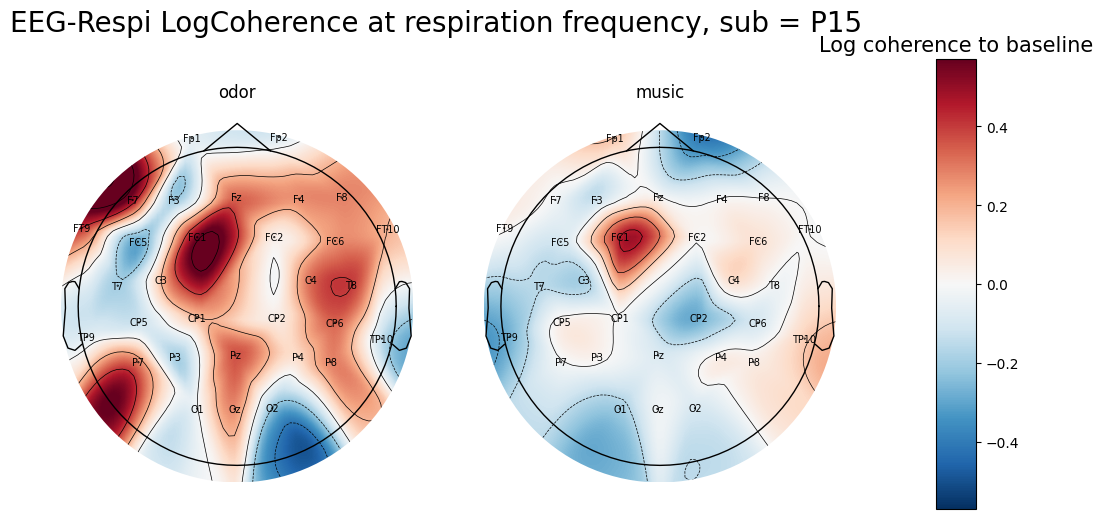

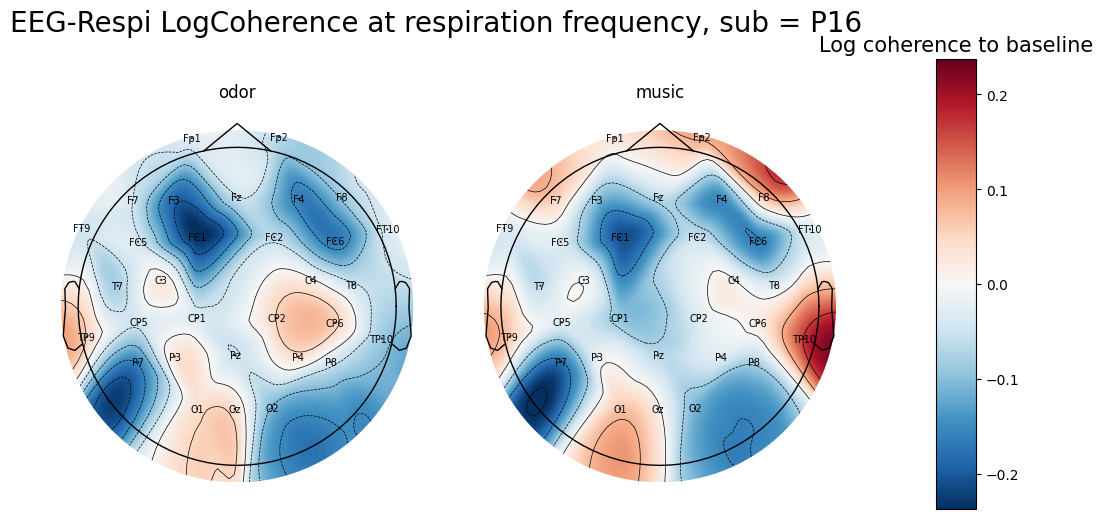

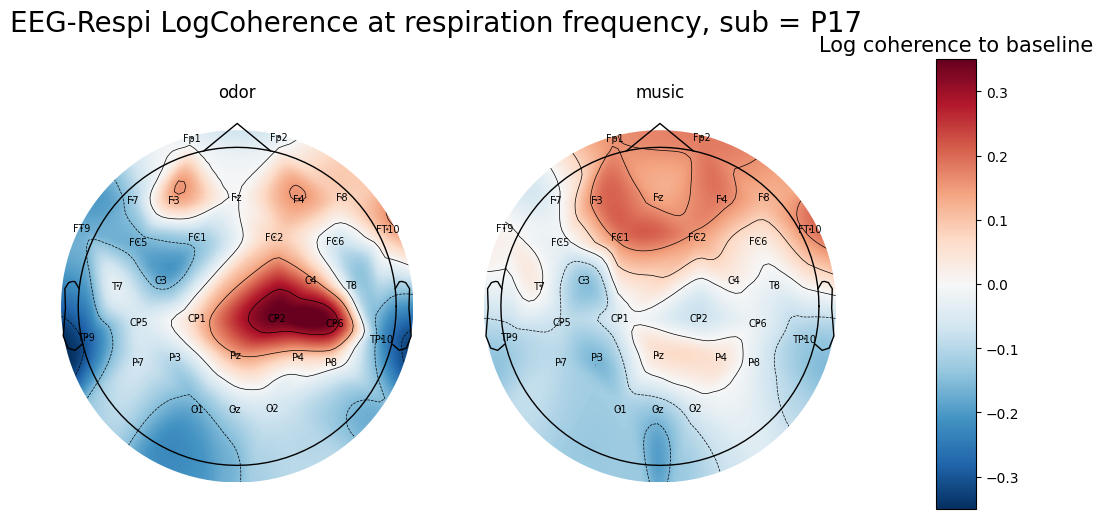

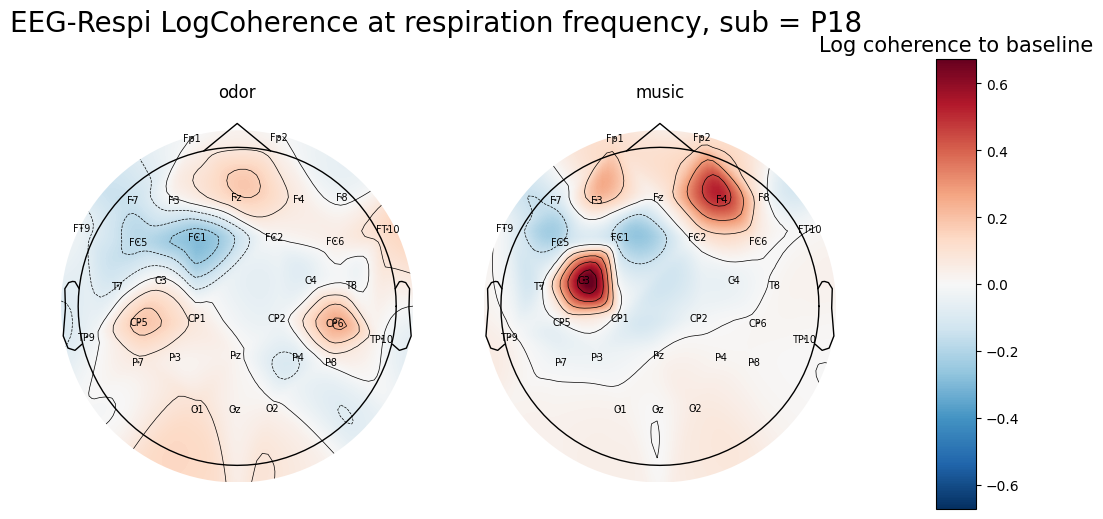

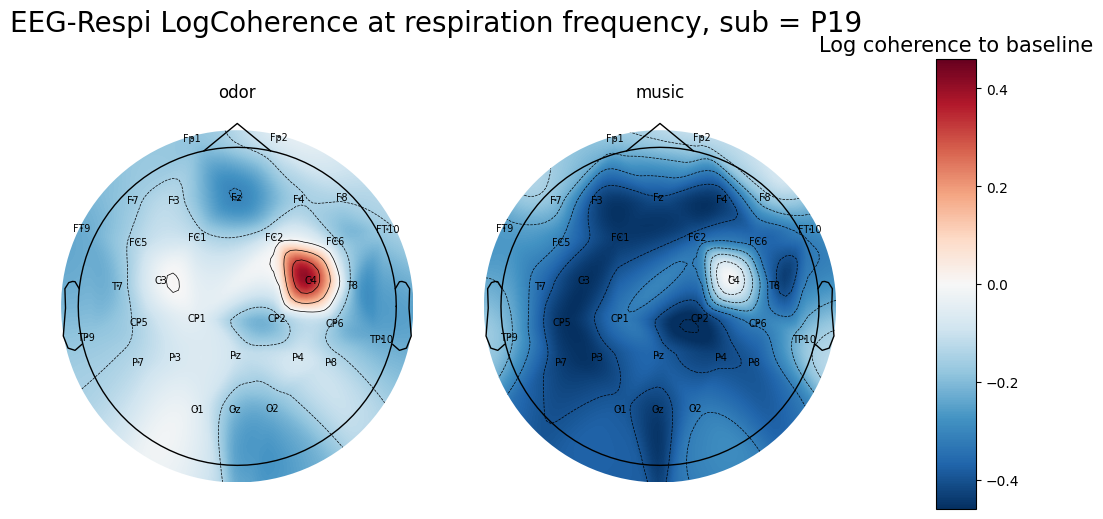

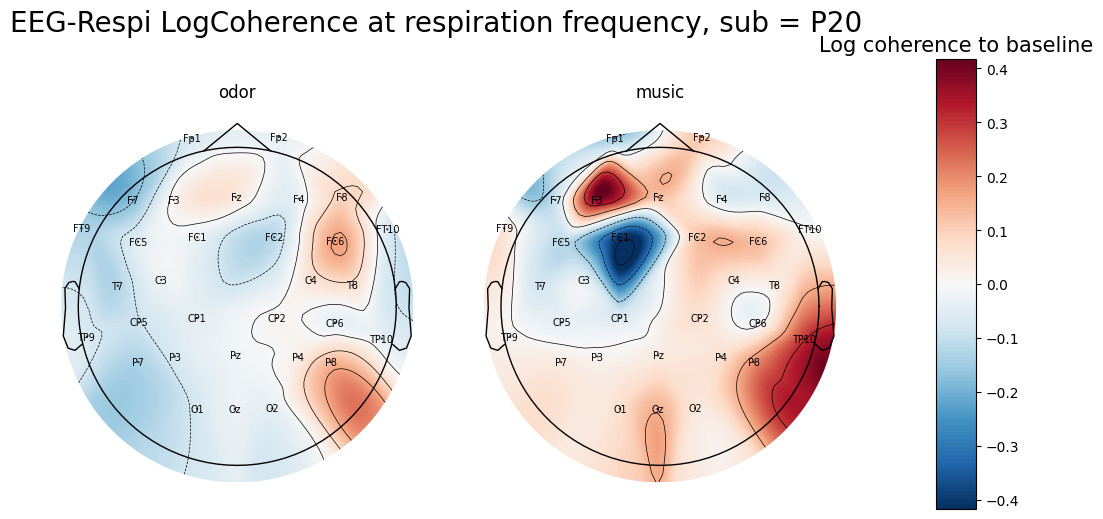

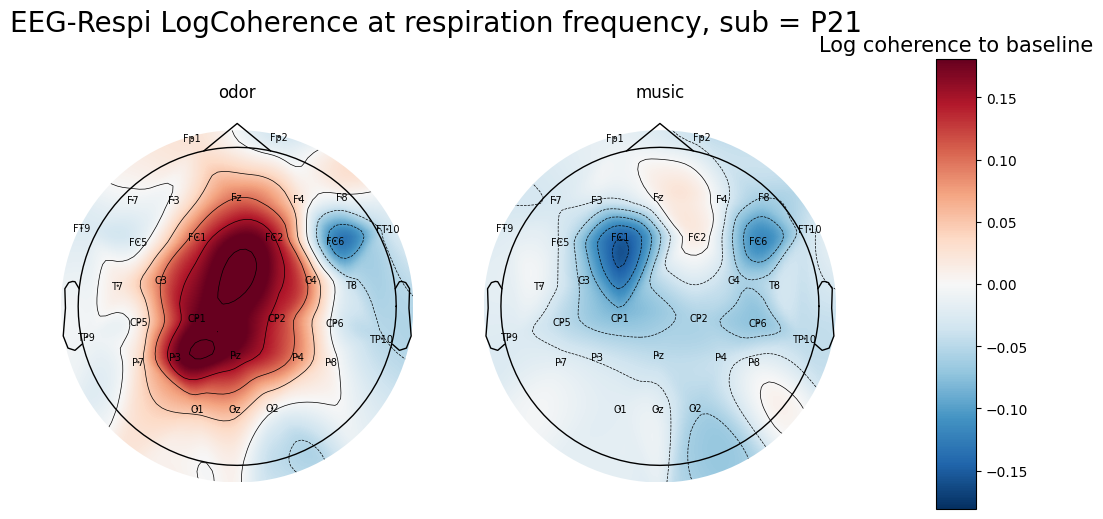

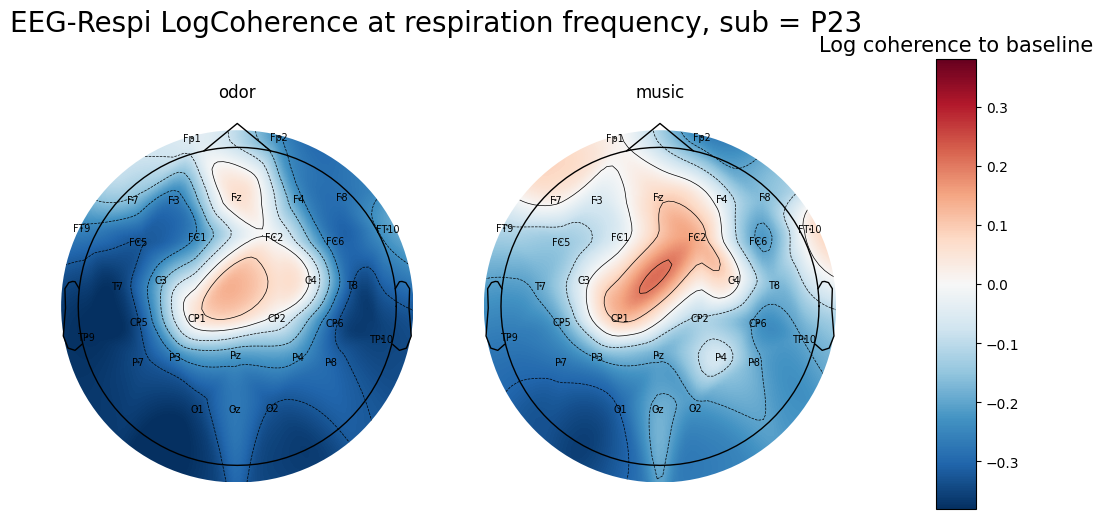

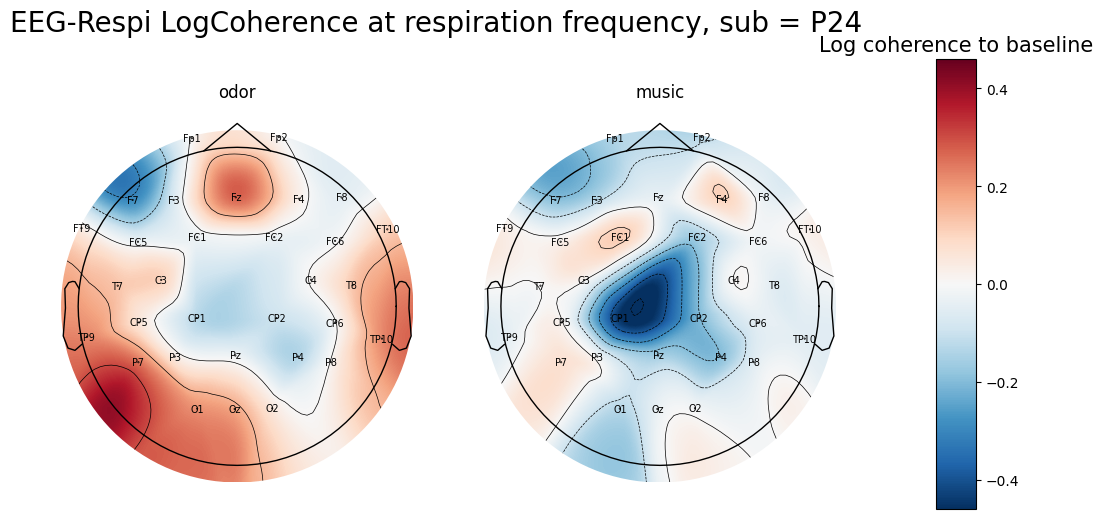

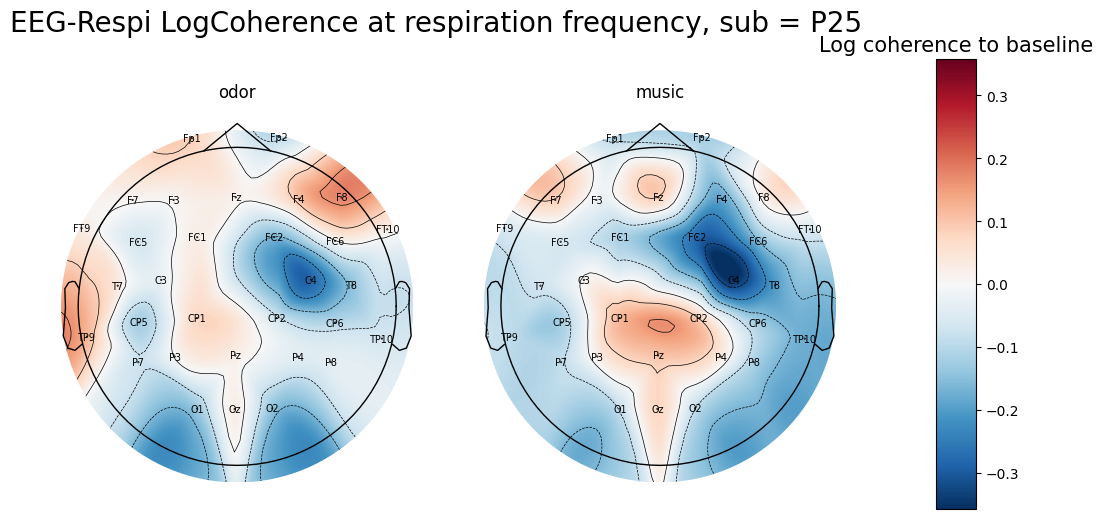

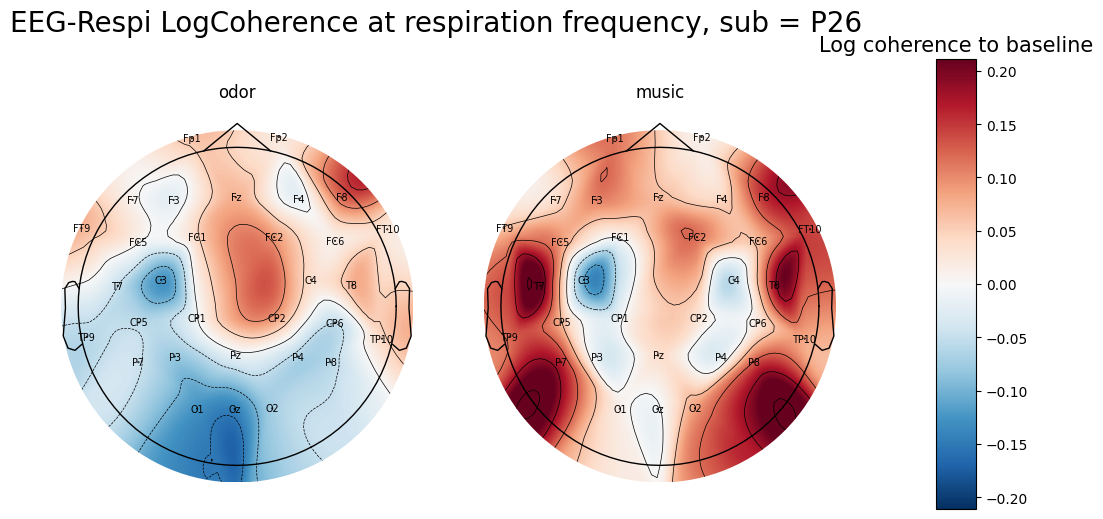

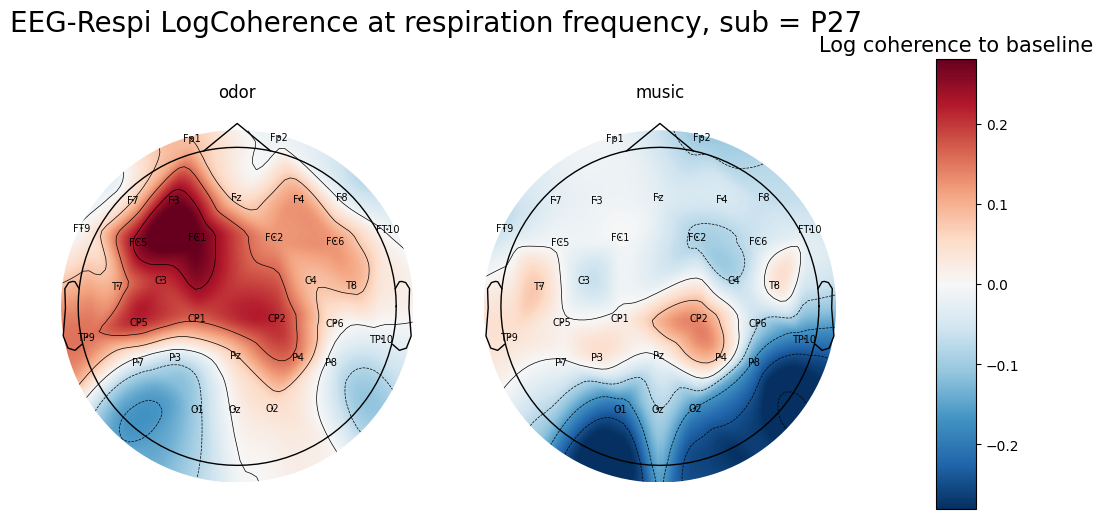

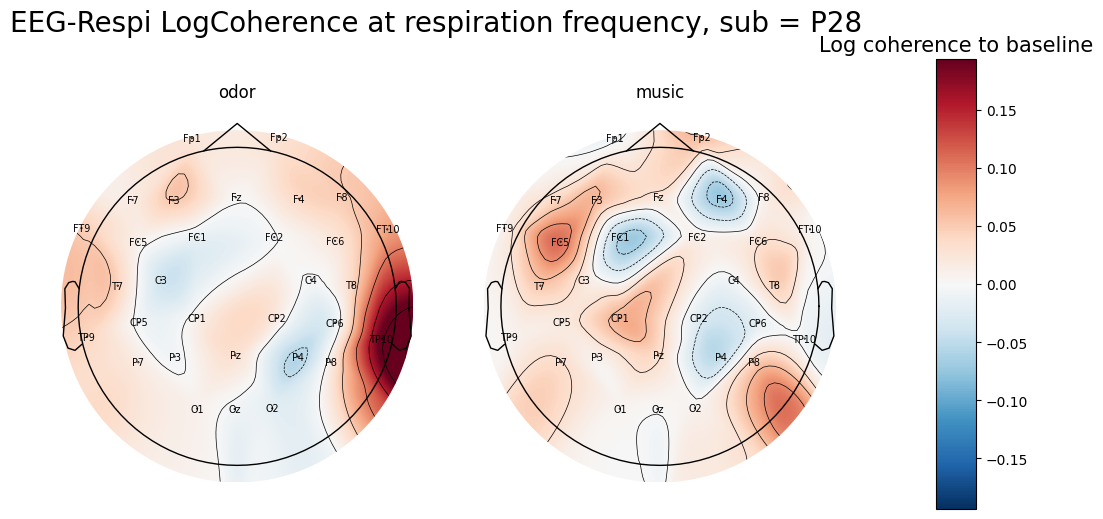

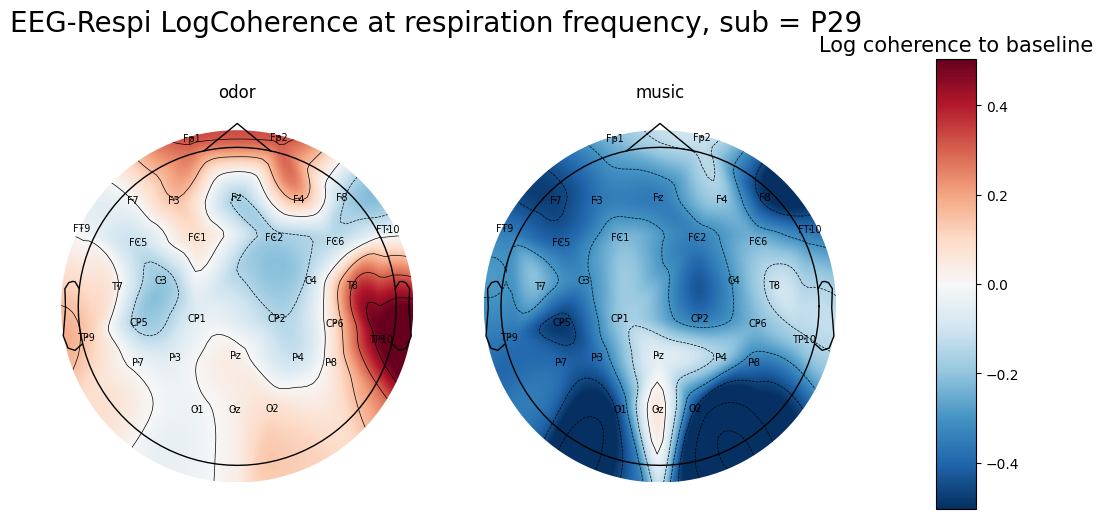

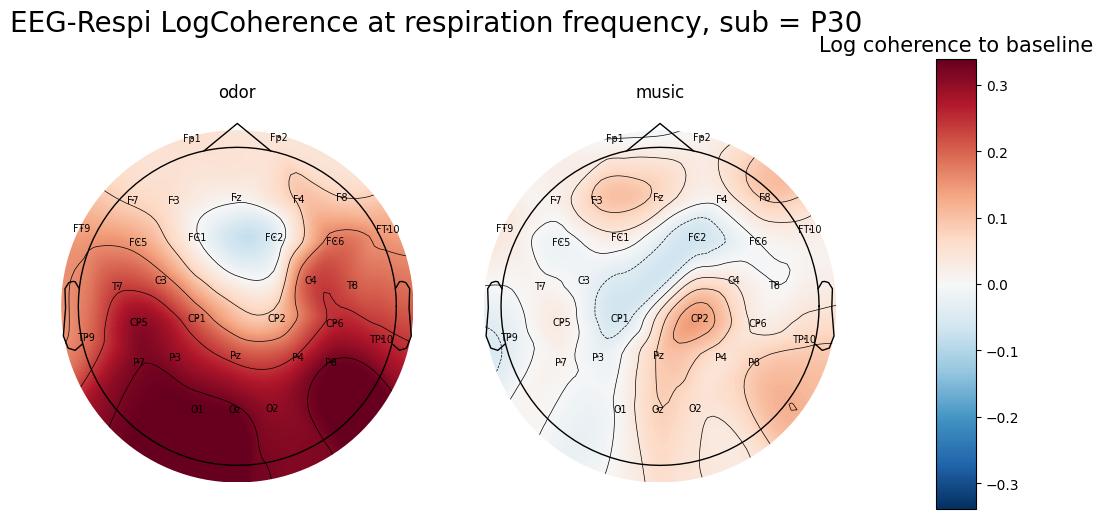

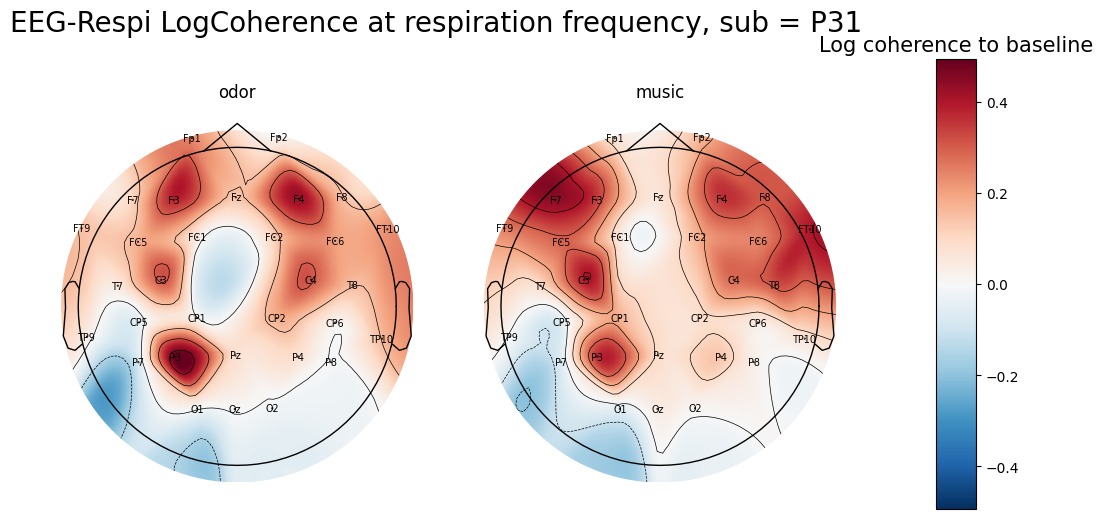

In [13]:
q_diff = 0.

for subject in subject_keys:
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Log coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    fig.show()